### Notebook for running pipeline in Colab

If you're running on colab: run these cells first!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/BEP/git/GPT-DT
!git status
!git pull
# Choose branch name here:
!git checkout evaluation-loop

In [ ]:
%pip install -r requirements-colab.txt

In [ ]:
# CLICK RESTART RUNTIME AND THEN RUN THIS CELL
%cd /content/drive/MyDrive/BEP/git/GPT-DT

### Main Code

In [1]:
%matplotlib inline
from main import *

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
c:\Users\Martijn\miniconda3\envs\BEP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
YOLOv5  2023-5-25 Python-3.9.16 torch-2.0.0 CPU



'utf-8' codec can't decode byte 0xff in position 0: invalid start byte


Fusing layers... 
Model summary: 476 layers, 76226352 parameters, 0 gradients, 110.1 GFLOPs
Adding AutoShape... 
Using cache found in C:\Users\Martijn/.cache\torch\hub\isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in C:\Users\Martijn/.cache\torch\hub\intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt
Loaded successfully


In [2]:
image = "vraag 12.jpg"
prompt, response, car_speed = run_program(image)


image 1/1 C:\Users\Martijn\Desktop\coding-projects\BEP\GPT-DT\images\vraag 12.jpg: 384x640 1 outside-view, 1 rear-view, 1 speed, 153.1ms
Speed: 0.0ms preprocess, 153.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to tri-crop\predict


1/1 [==============================] - 0s 230ms/step
not braking
1/1 [==============================] - 0s 48ms/step
not braking


In [5]:
truth = pd.read_csv("ground-truth.csv")
results = truth.copy(deep = True)
results["Answer(word)"] = None
results["Answer(letter)"] = None
results["Speed"] = None
results.insert(4, "Prompt", "", True)

In [6]:
from sklearn import metrics
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import concurrent.futures
%matplotlib inline

In [7]:
results.head()

,Filename,Answer(letter),Answer(word),Speed,Prompt
0,vraag 1.jpg,None,None,None,
1,vraag 2.jpg,None,None,None,
2,vraag 3.jpg,None,None,None,
3,vraag 4.jpg,None,None,None,
4,vraag 5.jpg,None,None,None,


In [ ]:
%%capture
# len(truth.index)

for row in range(len(truth.index)):
    tru_row = truth.loc[row]
    res_row = results.loc[row]

    image = tru_row["Filename"]
    prompt, response, car_speed = run_program(image)
    resp_char = response.strip(' \n\t')[0]

    if resp_char == 'A':
        resp_word = "Brake"
    elif resp_char == 'B':
        resp_word = "Release Accelerator"
    elif resp_char == 'C':
        resp_word = "Nothing"
    else:
        resp_word = "unknown"

    res_row["Answer(letter)"] = resp_char
    res_row["Speed"] = car_speed
    res_row["Answer(word)"] = resp_word

In [ ]:
res_row = results.loc[10]
res_row["Prompt"] = prompt
results.head(15)

In [5]:
confu = metrics.confusion_matrix(truth[["Answer(letter)"]], results[["Answer(letter)"]])
score = metrics.accuracy_score(truth[["Answer(letter)"]], results[["Answer(letter)"]])


In [ ]:
results

0.40350877192982454


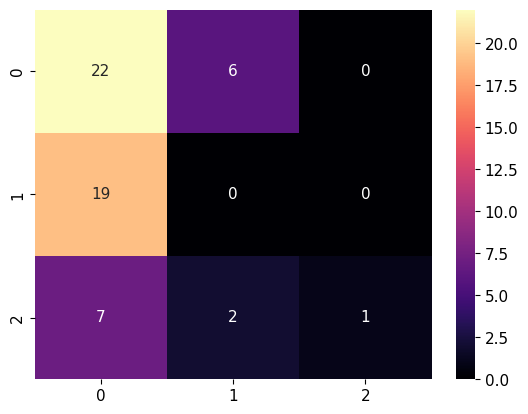

In [7]:
sns.heatmap(confu, annot=True, cmap='magma')
print(score)
plt.show()

In [8]:
df_speed_dif = results[["Speed"]].replace('unknown', 0).astype(float) - truth[["Speed"]].astype(float)
accuracy = len(df_speed_dif[df_speed_dif['Speed'] != 0])/len(truth)
print((1-accuracy))

0.9298245614035088


In [9]:
results.to_csv("results-gpt-3.5-2.csv")

In [ ]:
df_adjusted = pd.read_csv("results-gpt-3.5-adjusted.csv")
df_adjusted.head()

In [ ]:
df_run_1 = pd.read_csv("results-gpt-3.5.csv")
df_run_2 = pd.read_csv("results-gpt-3.5-2.csv")
df_merged = pd.merge(df_run_1, df_run_2)
df_merged = df_merged.drop_duplicates(keep=False)
df_merged

In [ ]:
#TODO implement asynchronous API call

def make_api_call(prompt):
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        temperature=0,
        stop=None,
        max_tokens=1024,
        n=1,
        messages=[
            {
                "role": "system",
                "content": "You are ChatGPT, a large language model trained by OpenAI. You are taking the dutch driving exam and wil be presented with what you see around you. Answer as concisely as possible and only take the dutch traffic rules in to consideration.",
            },
            {"role": "user", "content": prompt},
        ],
    )
    response = completion["choices"][0]["message"]["content"].strip()
    return response

for row in range(len(truth.index)):
    tru_row = truth.loc[row]
    res_row = results.loc[row]

    image = tru_row["Filename"]
    prompt, car_speed = run_program(image)
    res_row["Speed"] = car_speed
    res_row["Prompt"] = prompt

    # Create a ThreadPoolExecutor for concurrent API calls
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit the API calls as asynchronous tasks
        api_calls = executor.submit(make_api_call, prompt)
    

# Retrieve the results as they become available
for row, future in enumerate(concurrent.futures.as_completed(api_calls)):
    generated_text = future.result()
    results.loc[row, "Answer(word)"] = generated_text

# resp_char = response.strip(' \n\t')[0]

# if resp_char == 'A':
#     resp_word = "Brake"
# elif resp_char == 'B':
#     resp_word = "Release Accelerator"
# elif resp_char == 'C':
#     resp_word = "Nothing"
# else:
#     resp_word = "unknown"

# res_row["Answer(letter)"] = resp_char
# res_row["Speed"] = car_speed
# res_row["Answer(word)"] = resp_word